In [128]:
import gzip         # for reading .pkl.gz
import pickle       # to load the pickled dicts
import numpy as np  # for arrays, math
import matplotlib.pyplot as plt  # for plotting
from sklearn.metrics import r2_score
from scipy.stats import linregress
from matplotlib.colors import ListedColormap
from scipy.signal import find_peaks, peak_prominences, peak_widths
import matplotlib.cm as cm
# %matplotlib notebook
# %matplotlib widget
%matplotlib inline
import sys




In [129]:
def mesh_index_to_km(x):
    return (x / 299) * 110

def km_to_mesh_index(x):
    return (x / 110) * 299

Grounding Line plotting - Bedrock Erosion = 1.0 e -9

In [130]:
gl_run_title_be_1e9 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 1.00 E^-9")
be_1e9 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_27__13_10_19.pkl.gz"
with gzip.open(be_1e9, 'rb') as f:
    DATA_dict_be_1e9 = pickle.load(f)

In [131]:
bed_dict_1e9 = DATA_dict_be_1e9['bed_dict']
base_dict = DATA_dict_be_1e9['base_dict']
surf_dict= DATA_dict_be_1e9 ['surf_dict']
sed_dict = DATA_dict_be_1e9['sed_dict']
H_dict = DATA_dict_be_1e9['H_dict']
us_dict1e9 = DATA_dict_be_1e9['us_dict']
ub_dict = DATA_dict_be_1e9['ub_dict']
Hs_dict = DATA_dict_be_1e9['Hs_dict']
GL_dict = DATA_dict_be_1e9['GL_dict']
Qs_dict = DATA_dict_be_1e9['Qs_dict']

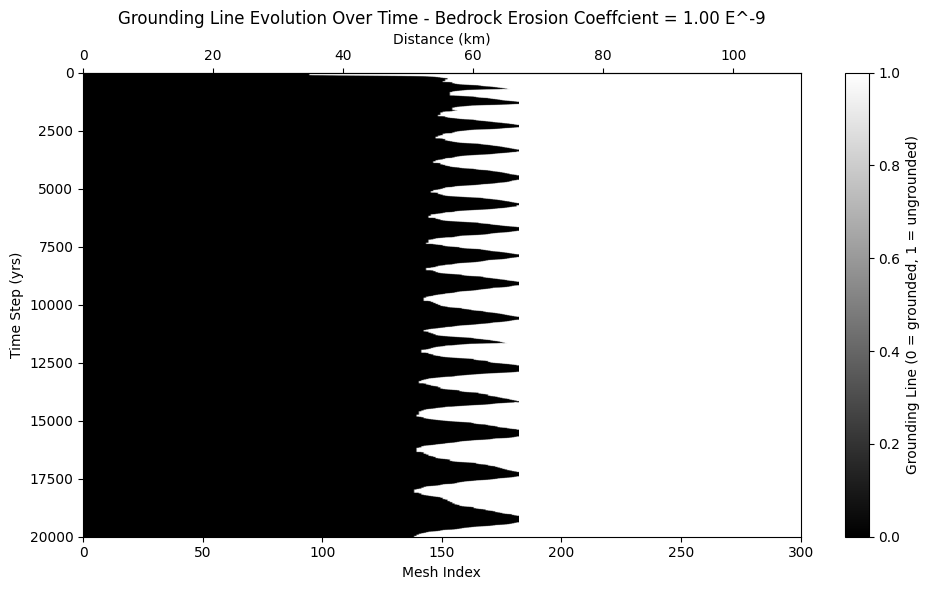

In [132]:
GL_dict = DATA_dict_be_1e9['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

cutoff_idx = np.argmax(x_km > 67)
mesh_indices_cut = mesh_indices[:cutoff_idx]
data_matrix_cut = data_matrix[:, :cutoff_idx]

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix_cut, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices_cut[0], mesh_indices_cut[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.set_xlim(0,300)
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_1e9)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [133]:
gl_positions_be_1e9 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_be_1e9.append(idx)

gl_positions_be_1e9 = np.array(gl_positions_be_1e9)
GL_km_be_1e9 = mesh_index_to_km(gl_positions_be_1e9)
mask = np.array(time) <= 10000
time = np.array(time)[mask]
GL_km_be_1e9 = GL_km_be_1e9[mask]


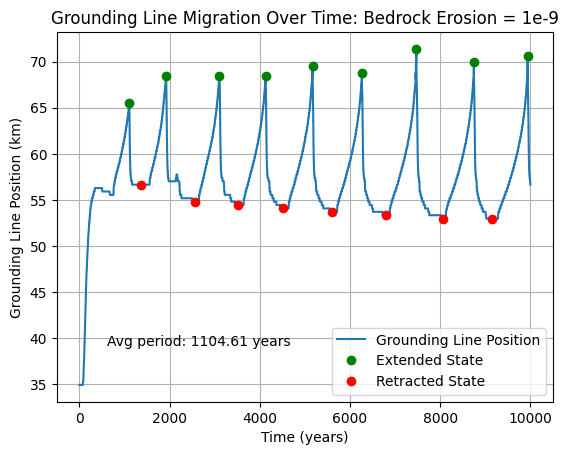

Mean cycle period: 1104.61 years
[ 817.42712774 1180.905683   1025.49975412 1041.53002828 1094.87646329
 1209.04509811 1273.92375981 1193.70325076]
Mean advance amplitude: 69.00 km
[65.48494983 68.42809365 68.42809365 68.42809365 69.53177258 68.79598662
 71.37123746 69.89966555 70.63545151]
Mean retreat amplitude: 54.13 km
[56.65551839 54.81605351 54.44816054 54.08026756 53.71237458 53.34448161
 52.97658863 52.97658863]


In [134]:
peaks_be_1e9, _ = find_peaks(GL_km_be_1e9, prominence=3) 
troughs_be_1e9, _ = find_peaks(-GL_km_be_1e9, prominence=3)     
periods_be_1e9 = np.diff(np.array(time)[peaks_be_1e9])
adv_dists_be_1e9 = GL_km_be_1e9[peaks_be_1e9]
ret_dists__be_1e9 = GL_km_be_1e9[troughs_be_1e9]


plt.plot(time, GL_km_be_1e9, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_be_1e9], GL_km_be_1e9[peaks_be_1e9], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_be_1e9], GL_km_be_1e9[troughs_be_1e9], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_be_1e9):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Bedrock Erosion = 1e-9")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_be_1e9):.2f} years")
print(periods_be_1e9)

print(f"Mean advance amplitude: {np.mean(adv_dists_be_1e9):.2f} km")
print(adv_dists_be_1e9)

print(f"Mean retreat amplitude: {np.mean(ret_dists__be_1e9):.2f} km")
print(ret_dists__be_1e9)


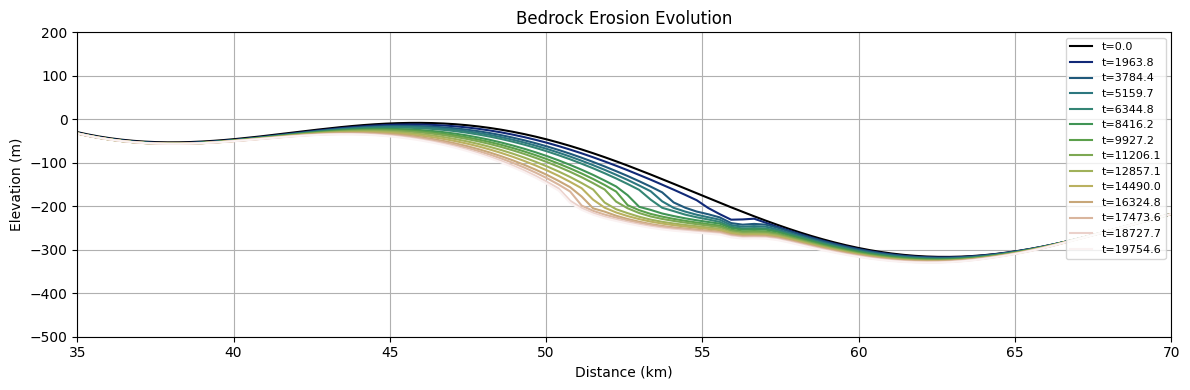

In [135]:
num_points = len(next(iter(bed_dict_1e9.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict_1e9.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.gist_earth

plt.figure(figsize=(12,4))

for i, t in enumerate(time):
    if i % 1000 != 0:  
        continue

    bed = bed_dict_1e9[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Bedrock Erosion Evolution")
# plt.gca().invert_xaxis() 
plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.xlim(35,70)
plt.ylim(-500,200)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)
plt.grid()
plt.tight_layout()
plt.show()

18103.14335845358


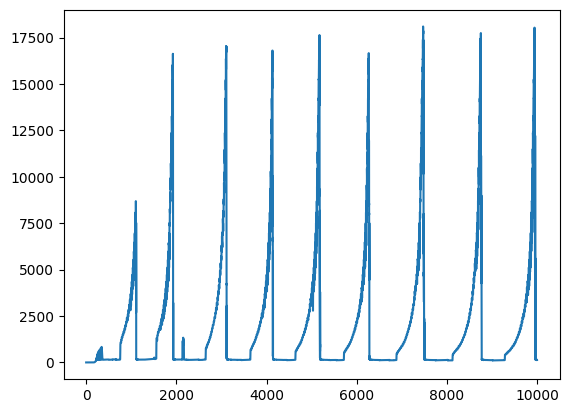

In [136]:
max_Qs1e9 = np.array([max(values) for values in Qs_dict.values()])
time_1e9 = np.array(list(Qs_dict.keys()))

mask = time_1e9 <= 10000

time_1e9 = time_1e9[mask]
max_Qs1e9 = max_Qs1e9[mask]
plt.plot(time_1e9, max_Qs1e9)
MAX_1e9 = np.max(max_Qs1e9)
print(MAX_1e9)

Grounding Line plotting - Bedrock Erosion = 5.5 e -9


In [184]:
gl_run_title_be_55e9 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 5.5e-9")
be_55e9 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_27__17_37_27.pkl.gz"
with gzip.open(be_55e9, 'rb') as f:
    DATA_dict_be_55e9 = pickle.load(f)

In [185]:
bed_dict_55e9 = DATA_dict_be_55e9['bed_dict']
base_dict = DATA_dict_be_55e9['base_dict']
surf_dict= DATA_dict_be_55e9 ['surf_dict']
sed_dict = DATA_dict_be_55e9['sed_dict']
H_dict = DATA_dict_be_55e9['H_dict']
us_dict55e9 = DATA_dict_be_55e9['us_dict']
ub_dict = DATA_dict_be_55e9['ub_dict']
Hs_dict = DATA_dict_be_55e9['Hs_dict']
GL_dict = DATA_dict_be_55e9['GL_dict']
Qs_dict = DATA_dict_be_55e9['Qs_dict']

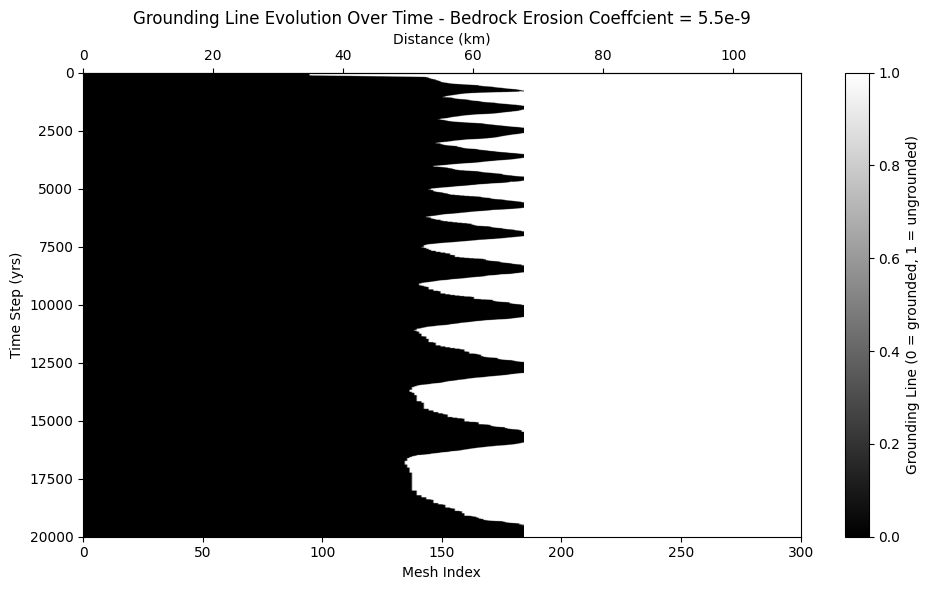

In [186]:
GL_dict = DATA_dict_be_55e9['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])
cutoff_idx = np.argmax(x_km > 68)
mesh_indices_cut = mesh_indices[:cutoff_idx]
data_matrix_cut = data_matrix[:, :cutoff_idx]

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix_cut, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices_cut[0], mesh_indices_cut[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.set_xlim(0,300)
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_55e9)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [187]:
gl_positions_be_55e9 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_be_55e9.append(idx)

gl_positions_be_55e9 = np.array(gl_positions_be_55e9)
GL_km_be_55e9 = mesh_index_to_km(gl_positions_be_55e9)
mask = np.array(time) <= 10000
time = np.array(time)[mask]
GL_km_be_55e9 = GL_km_be_55e9[mask]

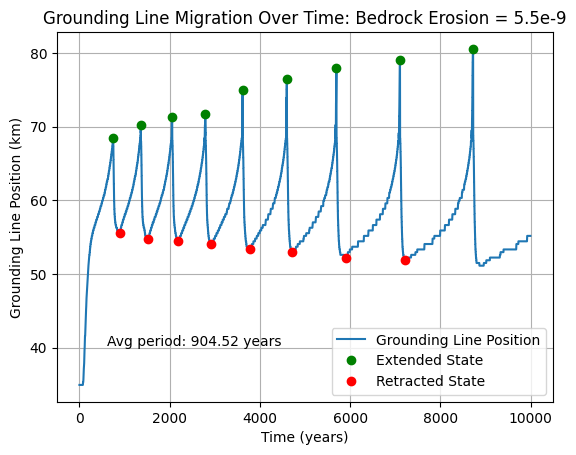

Mean cycle period: 904.52 years
[ 632.03860254  659.30847752  735.11160978  862.27045957  941.0296964
 1180.53415095 1321.32205577]
Mean advance amplitude: 74.56 km
[68.42809365 70.26755853 71.37123746 71.73913043 75.05016722 76.52173913
 77.99331104 79.09698997 80.56856187]
Mean retreat amplitude: 53.67 km
[55.55183946 54.81605351 54.44816054 54.08026756 53.34448161 52.97658863
 52.24080268 51.8729097 ]


In [188]:
peaks_be_55e9, _ = find_peaks(GL_km_be_55e9, prominence=6) 
troughs_be_55e9, _ = find_peaks(-GL_km_be_55e9, prominence=6)     
periods_be_55e9 = np.diff(np.array(time)[troughs_be_55e9])
adv_dists_be_55e9 = GL_km_be_55e9[peaks_be_55e9]
ret_dists__be_55e9 = GL_km_be_55e9[troughs_be_55e9]


plt.plot(time, GL_km_be_55e9, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_be_55e9], GL_km_be_55e9[peaks_be_55e9], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_be_55e9], GL_km_be_55e9[troughs_be_55e9], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_be_55e9):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Bedrock Erosion = 5.5e-9")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_be_55e9):.2f} years")
print(periods_be_55e9)

print(f"Mean advance amplitude: {np.mean(adv_dists_be_55e9):.2f} km")
print(adv_dists_be_55e9)

print(f"Mean retreat amplitude: {np.mean(ret_dists__be_55e9):.2f} km")
print(ret_dists__be_55e9)


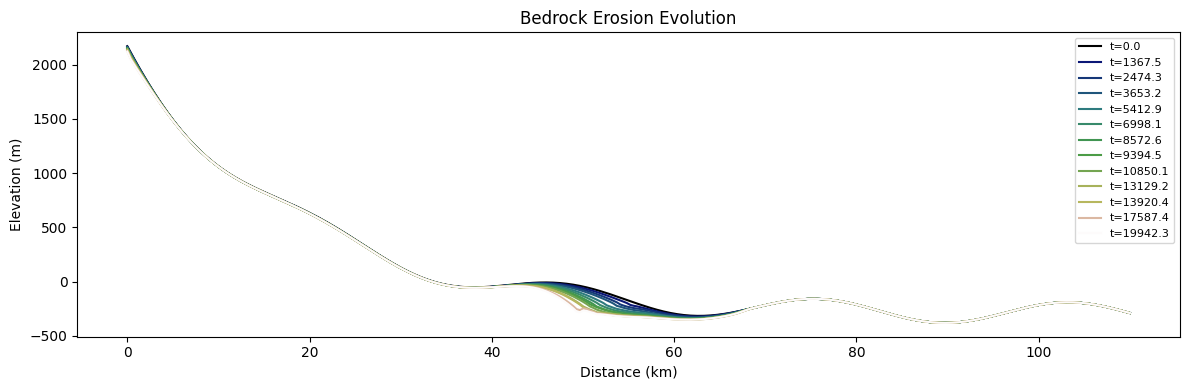

In [189]:
num_points = len(next(iter(bed_dict_55e9.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict_55e9.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.gist_earth

plt.figure(figsize=(12,4))

for i, t in enumerate(time):
    if i % 1000 != 0:  
        continue

    bed = bed_dict_55e9[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Bedrock Erosion Evolution")
# plt.gca().invert_xaxis() 
plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.xlim(35,70)
# plt.ylim(-500,200)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

21772.050175783657


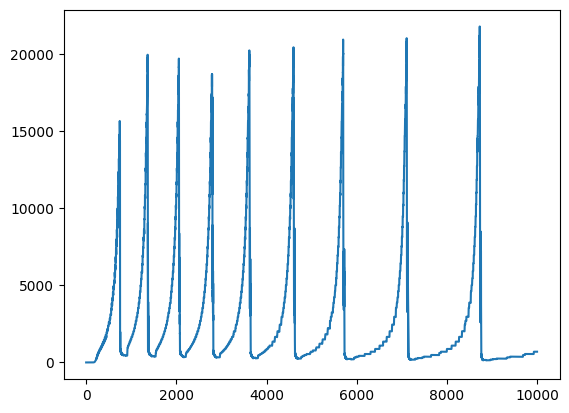

In [192]:
max_Qs55e9 = np.array([max(values) for values in Qs_dict.values()])
time_55e9 = np.array(list(Qs_dict.keys()))

mask = time_55e9 <= 10000

time_55e9 = time_55e9[mask]
max_Qs55e9 = max_Qs55e9[mask]
plt.plot(time_55e9, max_Qs55e9)
MAX_55e9 = np.max(max_Qs55e9)
print(MAX_55e9)



Grounding Line plotting - Bedrock Erosion = 1.0 e -8

In [203]:
gl_run_title_be_1e8 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 1.00 E^-8")
be_1e8 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_27__18_26_36.pkl.gz"
with gzip.open(be_1e8, 'rb') as f:
    DATA_dict_be_1e8 = pickle.load(f)

In [204]:
bed_dict_1e8 = DATA_dict_be_1e8['bed_dict']
base_dict = DATA_dict_be_1e8['base_dict']
surf_dict_1e8 = DATA_dict_be_1e8 ['surf_dict']
sed_dict = DATA_dict_be_1e8['sed_dict']
H_dict = DATA_dict_be_1e8['H_dict']
us_dict1e8 = DATA_dict_be_1e8['us_dict']
ub_dict = DATA_dict_be_1e8['ub_dict']
Hs_dict = DATA_dict_be_1e8['Hs_dict']
GL_dict = DATA_dict_be_1e8['GL_dict']
Qs_dict = DATA_dict_be_1e8['Qs_dict']

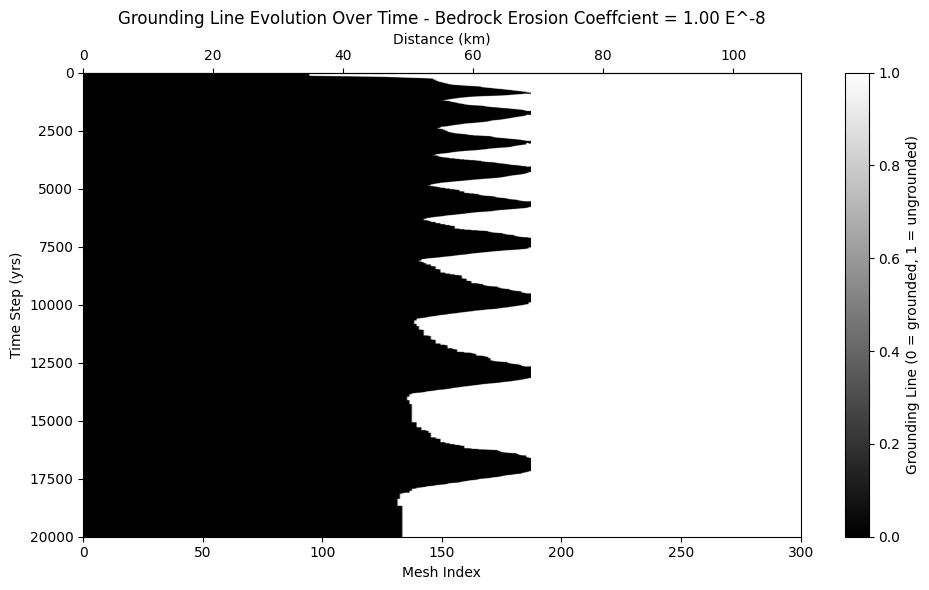

In [205]:
GL_dict = DATA_dict_be_1e8['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])
cutoff_idx = np.argmax(x_km > 69)
mesh_indices_cut = mesh_indices[:cutoff_idx]
data_matrix_cut = data_matrix[:, :cutoff_idx]

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix_cut, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices_cut[0], mesh_indices_cut[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.set_xlim(0,300)
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_1e8)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [206]:
gl_positions_be_1e8 = []
max_mesh_index = np.argmax(x_km > 70)  # Only consider mesh indices up to ~70 km

for row in data_matrix:
    # Limit search to region where GL is physically expected
    idx = np.argmax(row[:max_mesh_index] > 0.5)
    gl_positions_be_1e8.append(idx)

gl_positions_be_1e8 = np.array(gl_positions_be_1e8)
GL_km_be_1e8 = mesh_index_to_km(gl_positions_be_1e8)
mask = np.array(time) <= 10000
time = np.array(time)[mask]
GL_km_be_1e8 = GL_km_be_1e8[mask]

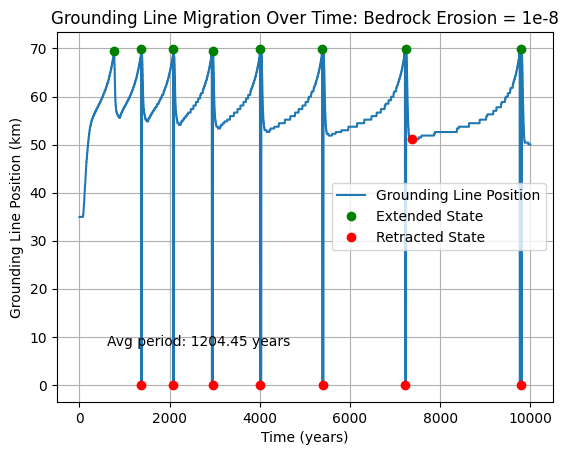

Mean cycle period: 1204.45 years
[ 706.515522    880.45871644 1047.75771013 1394.86616732 1827.64298613
  141.04766281 2432.84711123]
Mean advance amplitude: 69.81 km
[69.53177258 69.89966555 69.89966555 69.53177258 69.89966555 69.89966555
 69.89966555 69.89966555]
Mean retreat amplitude: 6.39 km
[ 0.          0.          0.          0.          0.          0.
 51.13712375  0.        ]


In [210]:
peaks_be_1e8, _ = find_peaks(GL_km_be_1e8, prominence=6, distance = 300) 
troughs_be_1e8, _ = find_peaks(-GL_km_be_1e8, prominence=12, distance = 500)     
periods_be_1e8 = np.diff(np.array(time)[troughs_be_1e8])
adv_dists_be_1e8 = GL_km_be_1e8[peaks_be_1e8]
ret_dists__be_1e8 = GL_km_be_1e8[troughs_be_1e8]


plt.plot(time, GL_km_be_1e8, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_be_1e8], GL_km_be_1e8[peaks_be_1e8], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_be_1e8], GL_km_be_1e8[troughs_be_1e8], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_be_1e8):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Bedrock Erosion = 1e-8")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_be_1e8):.2f} years")
print(periods_be_1e8)

print(f"Mean advance amplitude: {np.mean(adv_dists_be_1e8):.2f} km")
print(adv_dists_be_1e8)

print(f"Mean retreat amplitude: {np.mean(ret_dists__be_1e8):.2f} km")
print(ret_dists__be_1e8)


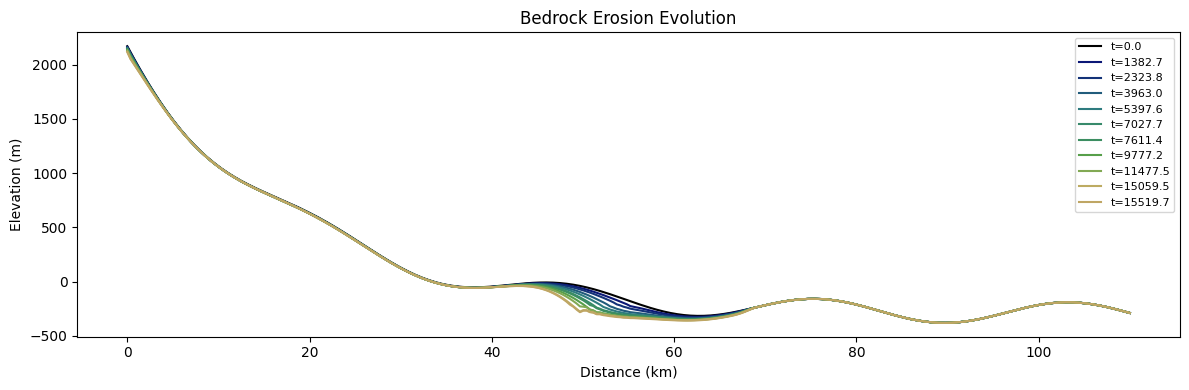

In [201]:
num_points = len(next(iter(bed_dict_1e8.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict_1e8.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.gist_earth

plt.figure(figsize=(12,4))

for i, t in enumerate(time):
    if i % 1000 != 0:  
        continue

    bed = bed_dict_1e8[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Bedrock Erosion Evolution")
# plt.gca().invert_xaxis() 
plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.xlim(35,70)
# plt.ylim(-500,200)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

22850.40539926036


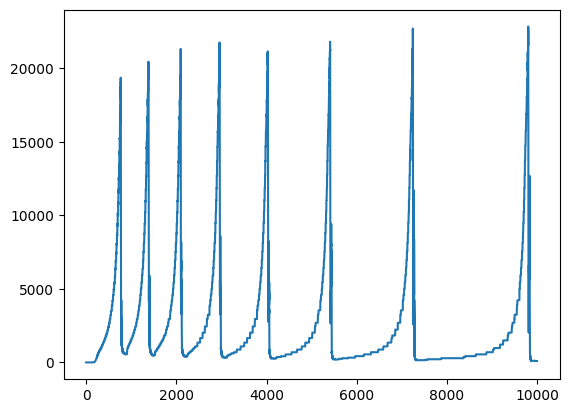

In [150]:
max_Qs1e8 = np.array([max(values) for values in Qs_dict.values()])
time_1e8 = np.array(list(Qs_dict.keys()))

mask = time_1e8 <= 10000

time_1e8 = time_1e8[mask]
max_Qs1e8 = max_Qs1e8[mask]
plt.plot(time_1e8, max_Qs1e8)
MAX_1e8 = np.max(max_Qs1e8)
print(MAX_1e8)

Grounding Line plotting - Bedrock Erosion = 5.5 e -8

In [151]:
gl_run_title_be_55e8 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 5.5e-8")
be_55e8 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_27__19_13_43.pkl.gz"
with gzip.open(be_55e8, 'rb') as f:
    DATA_dict_be_55e8 = pickle.load(f)

In [152]:
bed_dict_55e8 = DATA_dict_be_55e8['bed_dict']
base_dict = DATA_dict_be_55e8['base_dict']
surf_dict= DATA_dict_be_55e8 ['surf_dict']
sed_dict = DATA_dict_be_55e8['sed_dict']
H_dict = DATA_dict_be_55e8['H_dict']
us_dict55e8 = DATA_dict_be_55e8['us_dict']
ub_dict = DATA_dict_be_55e8['ub_dict']
Hs_dict = DATA_dict_be_55e8['Hs_dict']
GL_dict = DATA_dict_be_55e8['GL_dict']
Qs_dict = DATA_dict_be_55e8['Qs_dict']

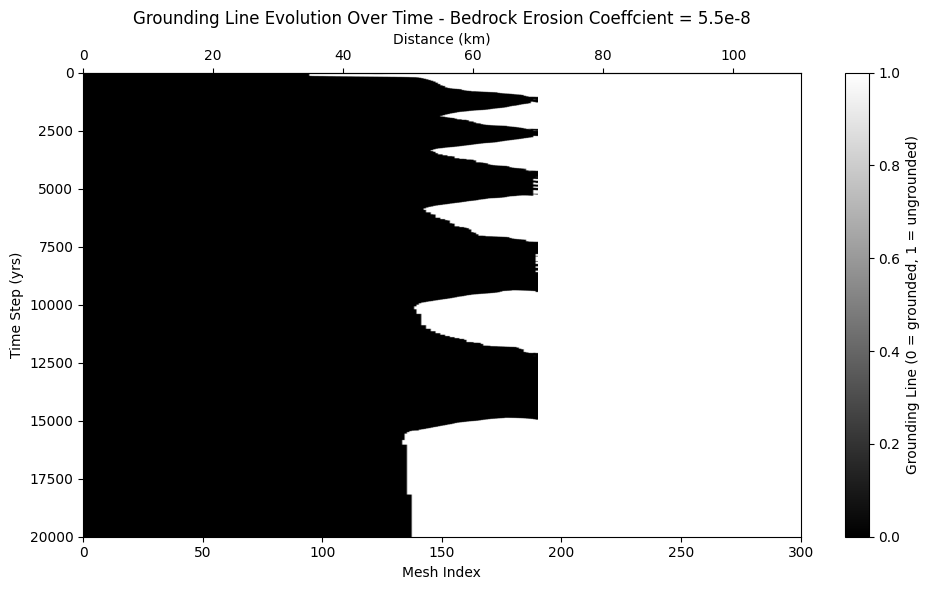

In [153]:
GL_dict = DATA_dict_be_55e8['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])
cutoff_idx = np.argmax(x_km > 70)
mesh_indices_cut = mesh_indices[:cutoff_idx]
data_matrix_cut = data_matrix[:, :cutoff_idx]

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix_cut, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices_cut[0], mesh_indices_cut[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.set_xlim(0,300)
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_55e8)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")


plt.tight_layout()
plt.show()

In [154]:
gl_positions_be_55e8 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_be_55e8.append(idx)

gl_positions_be_55e8 = np.array(gl_positions_be_55e8)
GL_km_be_55e8 = mesh_index_to_km(gl_positions_be_55e8)
mask = np.array(time) <= 10000
time = np.array(time)[mask]
GL_km_be_55e8 = GL_km_be_55e8[mask]


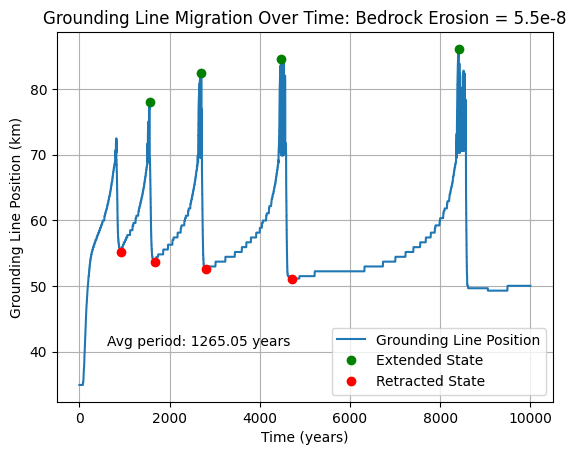

Mean cycle period: 1265.05 years
[ 748.31350285 1135.88367354 1910.95476972]
Mean advance amplitude: 82.78 km
[77.99331104 82.40802676 84.61538462 86.08695652]
Mean retreat amplitude: 53.16 km
[55.18394649 53.71237458 52.60869565 51.13712375]


In [155]:
peaks_be_55e8, _ = find_peaks(GL_km_be_55e8, prominence=8, distance = 900) 

pruned_peaks = []
last_time = -np.inf
min_time_diff = 200  # in years

for p in peaks_be_55e8:
    t = time[p]
    if t - last_time >= min_time_diff:
        pruned_peaks.append(p)
        last_time = t

pruned_peaks = np.array(pruned_peaks)
peaks_be_55e8, _ = find_peaks(GL_km_be_55e8, prominence=15, distance = 700) 
troughs_be_55e8, _ = find_peaks(-GL_km_be_55e8, prominence=15, distance = 700)     
periods_be_55e8 = np.diff(np.array(time)[troughs_be_55e8])
adv_dists_be_55e8 = GL_km_be_55e8[pruned_peaks]
ret_dists__be_55e8 = GL_km_be_55e8[troughs_be_55e8]


plt.plot(time, GL_km_be_55e8, label='Grounding Line Position')
plt.plot(np.array(time)[pruned_peaks], GL_km_be_55e8[pruned_peaks], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_be_55e8], GL_km_be_55e8[troughs_be_55e8], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_be_55e8):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Bedrock Erosion = 5.5e-8")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_be_55e8):.2f} years")
print(periods_be_55e8)

print(f"Mean advance amplitude: {np.mean(adv_dists_be_55e8):.2f} km")
print(adv_dists_be_55e8)

print(f"Mean retreat amplitude: {np.mean(ret_dists__be_55e8):.2f} km")
print(ret_dists__be_55e8)


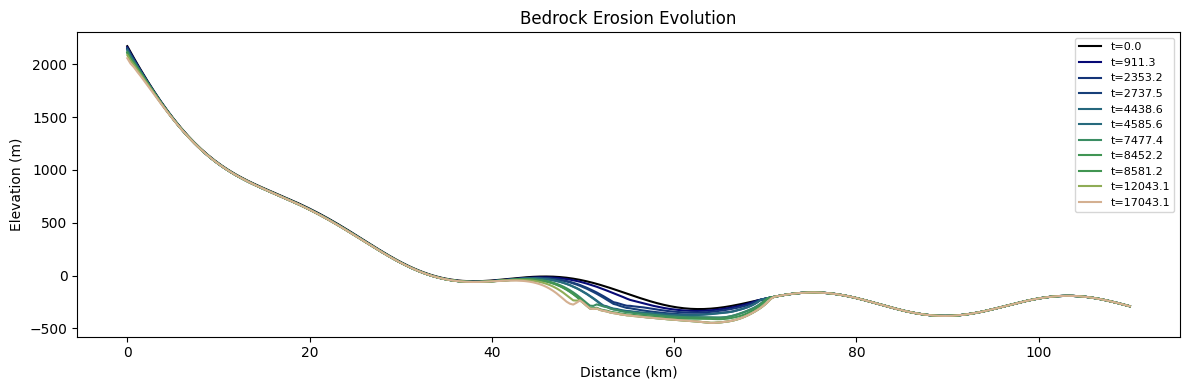

In [156]:
num_points = len(next(iter(bed_dict_55e8.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict_55e8.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.gist_earth

plt.figure(figsize=(12,4))

for i, t in enumerate(time):
    if i % 1000 != 0:  
        continue

    bed = bed_dict_55e8[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Bedrock Erosion Evolution")
# plt.gca().invert_xaxis() 
plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.xlim(35,70)
# plt.ylim(-500,200)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

35438.29751484113


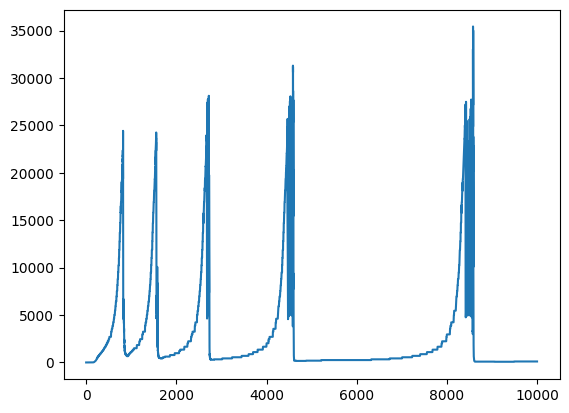

In [157]:
max_Qs55e8 = np.array([max(values) for values in Qs_dict.values()])
time_55e8 = np.array(list(Qs_dict.keys()))

mask = time_55e8 <= 10000

time_55e8 = time_55e8[mask]
max_Qs55e8 = max_Qs55e8[mask]
plt.plot(time_55e8, max_Qs55e8)
MAX_55e8 = np.max(max_Qs55e8)
print(MAX_55e8)

Grounding Line plotting - Bedrock Erosion = 1.0 e -7

In [158]:
gl_run_title_be_1e7 = str("Grounding Line Evolution Over Time - Bedrock Erosion Coeffcient = 1.00 E^-7")
be_1e7 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_27__21_53_13.pkl.gz"
with gzip.open(be_1e7, 'rb') as f:
    DATA_dict_be_1e7 = pickle.load(f)

In [159]:
bed_dict_1e7 = DATA_dict_be_1e7['bed_dict']
base_dict = DATA_dict_be_1e7['base_dict']
surf_dict= DATA_dict_be_1e7 ['surf_dict']
sed_dict = DATA_dict_be_1e7['sed_dict']
H_dict = DATA_dict_be_1e7['H_dict']
us_dict1e7 = DATA_dict_be_1e7['us_dict']
ub_dict = DATA_dict_be_1e7['ub_dict']
Hs_dict = DATA_dict_be_1e7['Hs_dict']
GL_dict = DATA_dict_be_1e7['GL_dict']
Qs_dict = DATA_dict_be_1e7['Qs_dict']

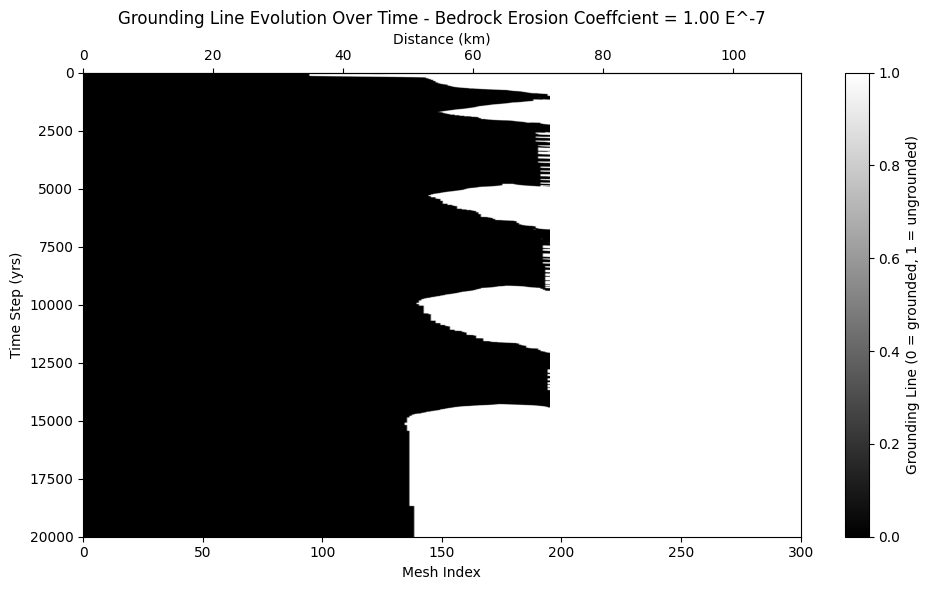

In [160]:
GL_dict = DATA_dict_be_1e7['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])
x_km = mesh_index_to_km(mesh_indices)
cutoff_idx = np.argmax(x_km > 72)
mesh_indices_cut = mesh_indices[:cutoff_idx]
data_matrix_cut = data_matrix[:, :cutoff_idx]



fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix_cut, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices_cut[0], mesh_indices_cut[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.set_xlim(0,300)
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_be_1e7)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [161]:
mask = np.array(time) <= 10000
time = np.array(time)[mask]

print(len(time))                # should be 10385 originally
print(data_matrix_cut.shape)    # should be (10385, N)

data_matrix_cut = data_matrix_cut[mask, :]


gl_positions_be_1e7 = []
for row in data_matrix_cut:
    idx = np.argmax(row > 0.5)
    gl_positions_be_1e7.append(idx)

gl_positions_be_1e7 = np.array(gl_positions_be_1e7)
GL_km_be_1e7 = mesh_index_to_km(gl_positions_be_1e7)


8384
(10385, 196)


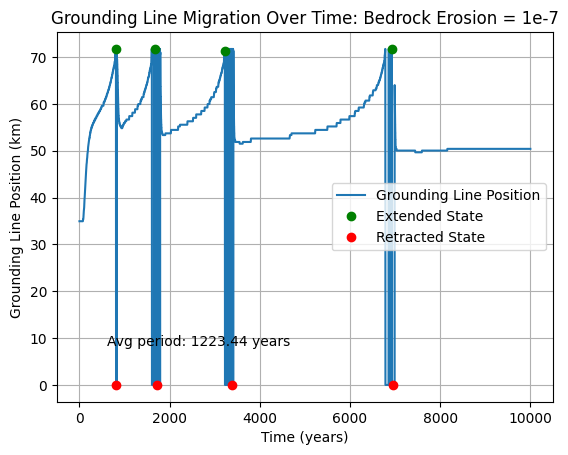

Mean cycle period: 1223.44 years
[ 870.95204461  107.6552132  1432.25938748  156.24228381 3550.09430347]
Mean advance amplitude: 71.65 km
[71.73913043 71.73913043 71.37123746 71.73913043]
Mean retreat amplitude: 0.00 km
[0. 0. 0. 0.]
[ 512 1476 2417 3511 4556 7080]


In [162]:
peaks_be_1e7, _ = find_peaks(GL_km_be_1e7, prominence=8, distance = 900) 

pruned_peaks = []
last_time = -np.inf
min_time_diff = 200  # in years

for p in peaks_be_1e7:
    t = time[p]
    if t - last_time >= min_time_diff:
        pruned_peaks.append(p)
        last_time = t

pruned_peaks = np.array(pruned_peaks)

troughs_be_1e7, _ = find_peaks(-GL_km_be_1e7, prominence=18, distance = 1000)     
periods_be_1e7 = np.diff(np.array(time)[peaks_be_1e7])
adv_dists_be_1e7 = GL_km_be_1e7[pruned_peaks]
ret_dists__be_1e7 = GL_km_be_1e7[troughs_be_1e7]


plt.plot(time, GL_km_be_1e7, label='Grounding Line Position')
plt.plot(np.array(time)[pruned_peaks], GL_km_be_1e7[pruned_peaks], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_be_1e7], GL_km_be_1e7[troughs_be_1e7], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_be_1e7):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Bedrock Erosion = 1e-7")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_be_1e7):.2f} years")
print(periods_be_1e7)

print(f"Mean advance amplitude: {np.mean(adv_dists_be_1e7):.2f} km")
print(adv_dists_be_1e7)

print(f"Mean retreat amplitude: {np.mean(ret_dists__be_1e7):.2f} km")
print(ret_dists__be_1e7)

print(peaks_be_1e7)

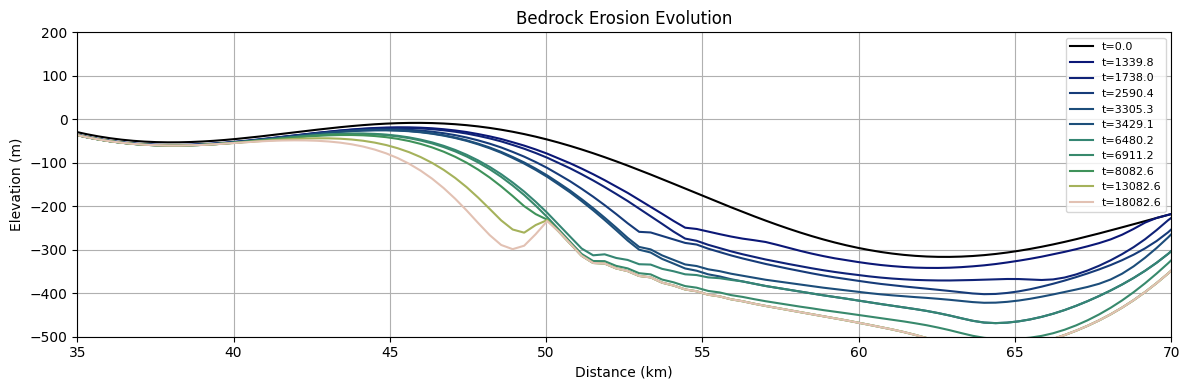

In [163]:
num_points = len(next(iter(bed_dict_1e7.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict_1e7.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.gist_earth

plt.figure(figsize=(12,4))

for i, t in enumerate(time):
    if i % 1000 != 0:  
        continue

    bed = bed_dict_1e7[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Bedrock Erosion Evolution")
# plt.gca().invert_xaxis() 
plt.legend(loc="best", fontsize=8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.xlim(35,70)
plt.ylim(-500,200)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)
plt.grid()
plt.tight_layout()
plt.show()

42793.63607095882


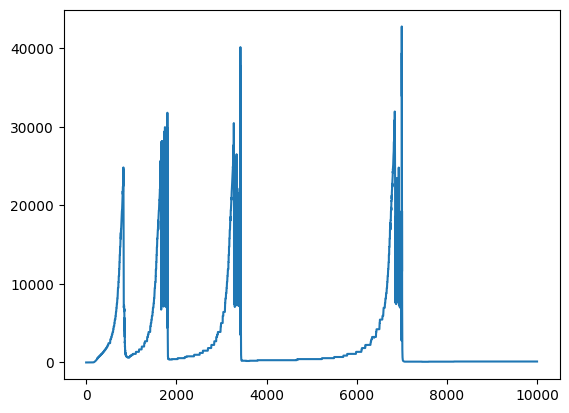

In [164]:
max_Qs1e7 = np.array([max(values) for values in Qs_dict.values()])
time_1e7 = np.array(list(Qs_dict.keys()))

mask = time_1e7 <= 10000

time_1e7 = time_1e7[mask]
max_Qs1e7 = max_Qs1e7[mask]
plt.plot(time_1e7, max_Qs1e7)
MAX_1e7 = np.max(max_Qs1e7)
print(MAX_1e7)

## Relationship Plots

In [165]:
## Bedrock Erosion ##
title_BE_cycles = str("Cycles per 10,000 Years: Bedrock Erosion")
BEs = np.array([1e-9, 5.5e-9, 1e-8, 5.5e-8, 1e-7])
BE_cycles = np.array([9, 9, 8, 5, 4])
BE_coeff = np.polyfit(BEs,BE_cycles, 1)
p_BE = np.poly1d(BE_coeff)
BE_y_trend = p_BE(BEs)
R_2_BE =r2_score(BE_cycles,p_BE(BEs))

log_BEs = np.log10(BEs)
slope, intercept, r_value, _, _ = linregress(log_BEs, BE_cycles)
BE_y_trend = slope * log_BEs + intercept


y = -2.72 log(x) + -14.53


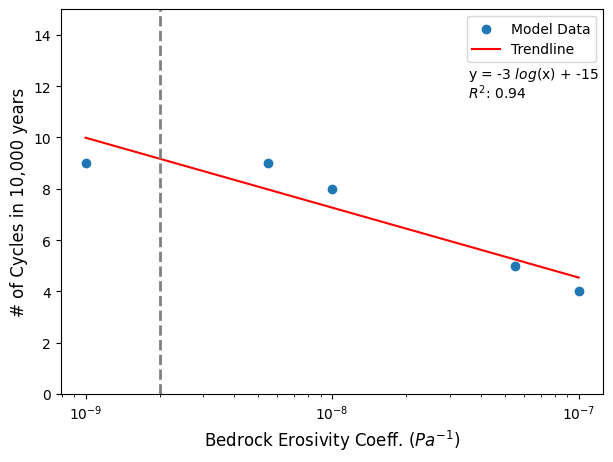

In [220]:
fig, ax1 = plt.subplots(figsize=(7,5))

plt.scatter(BEs, BE_cycles, label = 'Model Data')
# plt.title('Cycle Frequency: Bedrock Erosivity Coefficient', fontsize = 13)
plt.plot(BEs, BE_y_trend, color='red', label='Trendline')
plt.text(0.75, 0.77, f'$R^2$: {R_2_BE:.2f}', transform=plt.gca().transAxes)
plt.text(0.75, 0.82, f'y = {slope:.0f} $log$(x) + {intercept:.0f}', transform=plt.gca().transAxes)
plt.axvline(x=2e-9, color='gray', linestyle='--', linewidth=2)
plt.xlabel("Bedrock Erosivity Coeff. ($Pa^{-1}$)", fontsize = 12)
plt.xscale('log')
plt.ylim(0,15)
plt.ylabel("# of Cycles in 10,000 years", fontsize = 12)
plt.legend(loc=1)
# plt.xticks(np.arange(1e-9, 1e-8, 1e-7)) 

fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/BE_cycles_EQ.svg", format ="svg", bbox_inches='tight')
print(f'y = {slope:.2f} log(x) + {intercept:.2f}')

In [167]:
Period_list = [periods_be_1e9, periods_be_55e9, periods_be_1e8, periods_be_55e8, periods_be_1e7]

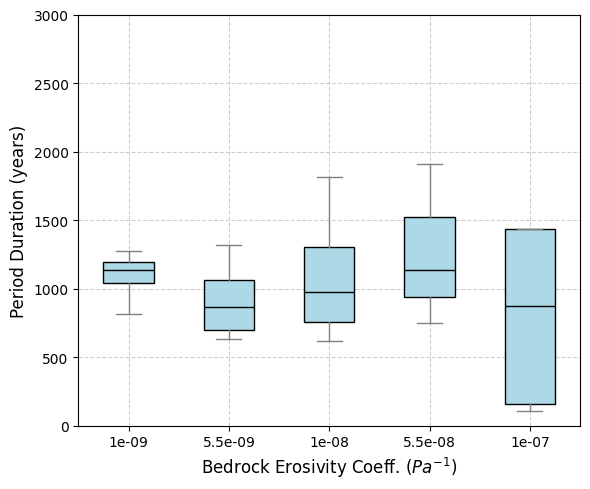

In [221]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(Period_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

# ax.set_title("Cycle Period Variations: Bedrock Erosivity Coeff.", fontsize = 15)
ax.set_ylabel("Period Duration (years)", fontsize =12)
ax.set_xlabel("Bedrock Erosivity Coeff. ($Pa^{-1}$)", fontsize = 12)
ax.set_xticks(np.arange(1, len(BEs) + 1))
ax.set_xticklabels(BEs)
ax.set_ylim(0,3000)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/BE_period_janky.svg", format ="svg", bbox_inches='tight')


In [169]:
ExtPos_list =  [adv_dists_be_1e9, adv_dists_be_55e9, adv_dists_be_1e8,adv_dists_be_55e8, adv_dists_be_1e7]


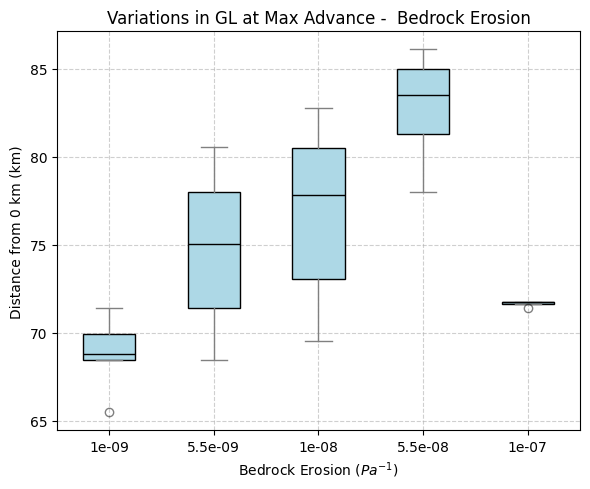

[71.73913043 71.73913043 71.37123746 71.73913043]


In [170]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Max Advance -  Bedrock Erosion")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Bedrock Erosion ($Pa^{-1}$)")
ax.set_xticks(np.arange(1, len(BEs) + 1))
ax.set_xticklabels(BEs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print(adv_dists_be_1e7)

In [171]:
RetPos_list =  [ret_dists__be_1e9, ret_dists__be_55e9, ret_dists__be_1e8, ret_dists__be_55e8,  ret_dists__be_1e7 ]

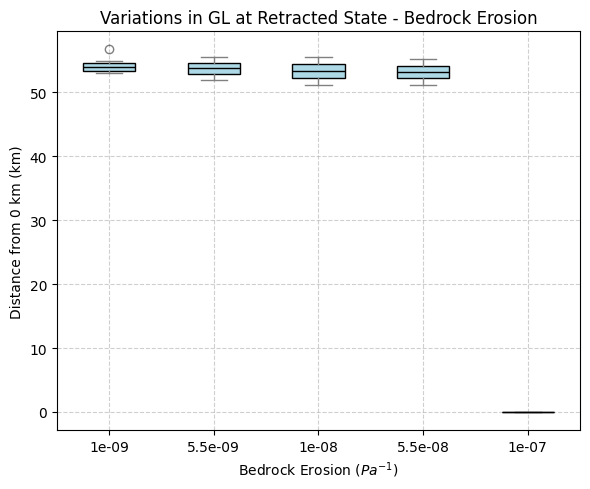

In [172]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Retracted State - Bedrock Erosion")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Bedrock Erosion ($Pa^{-1}$)")
ax.set_xticks(np.arange(1, len(BEs) + 1))
ax.set_xticklabels(BEs)
ax.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

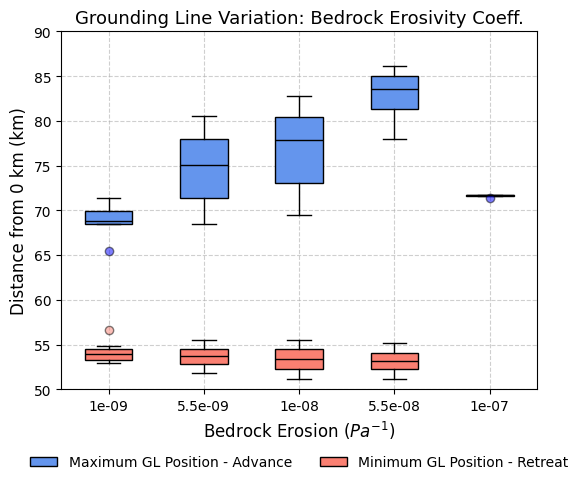

In [173]:
fig, ax = plt.subplots(figsize=(6, 5))

D2 = ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='salmon'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='salmon', alpha=0.5))

D1 = ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='cornflowerblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='blue', alpha=0.5))

ax.set_title("Grounding Line Variation: Bedrock Erosivity Coeff.", fontsize = 13)
ax.set_ylabel("Distance from 0 km (km)", fontsize = 12)
ax.set_xlabel("Bedrock Erosion ($Pa^{-1}$)", fontsize = 12)
ax.legend([D1["boxes"][0], D2["boxes"][0]], ['Maximum GL Position - Advance', 'Minimum GL Position - Retreat'], loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=2, frameon=False)
ax.set_xticks(np.arange(1, len(BEs) + 1))
ax.set_xticklabels(BEs)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_ylim(50,90)
plt.tight_layout()
plt.show()
fig.savefig("/home/kayatroyer/Repositories/brinkmodeltest/Output/GL_Variation_BE.svg", format ="svg", bbox_inches='tight')

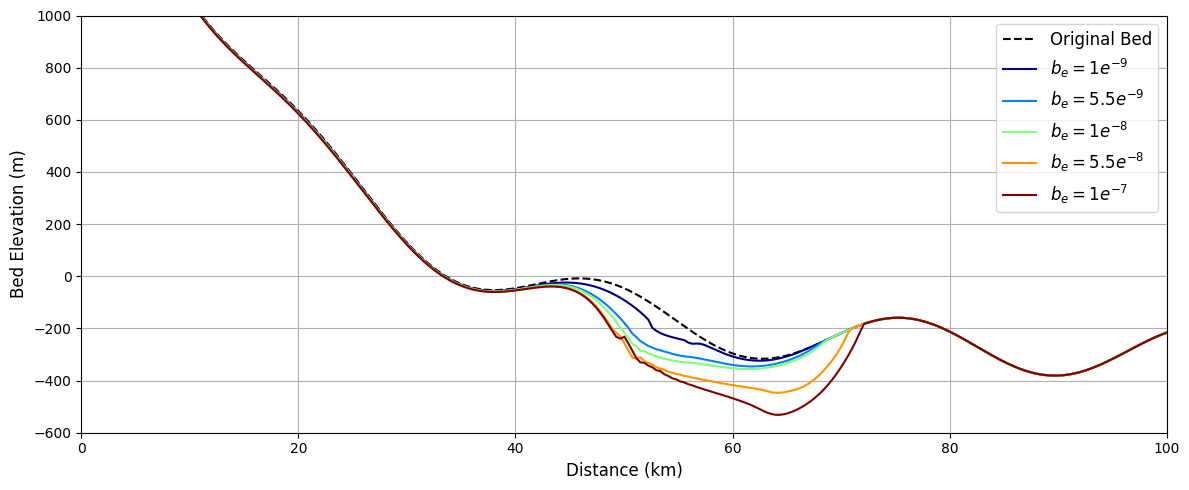

In [230]:
BEs = np.array([1e-9, 5.5e-9, 1e-8, 5.5e-8, 1e-7])
num_points = len(next(iter(bed_dict_1e9.values())))
x_km = mesh_index_to_km(np.arange(num_points))

# Grab original bed (assuming t=0 in all dicts)
original_bed = bed_dict_1e9[0]

# Create figure
fig, ax = plt.subplots(figsize=(12, 5))

# Plot original bed
plt.plot(x_km, original_bed, 'k--', label='Original Bed')

# List of erosion cases to loop through
bed_dicts = [bed_dict_1e9, bed_dict_55e9, bed_dict_1e8, bed_dict_55e8, bed_dict_1e7]
labels = ['$b_e = 1e^{{-9}}$','$b_e = 5.5e^{{-9}}$', '$b_e = 1e^{{-8}}$', '$b_e = 5.5e^{{-8}}$', '$b_e = 1e^{{-7}}$']
colors = plt.cm.jet(np.linspace(0, 1, len(bed_dicts)))

max_time = 10000 

for bed_dict, label, color in zip(bed_dicts, labels, colors):
    times = np.array(list(bed_dict.keys()))
    mask = times <= max_time

    if not np.any(mask):
        continue  # skip if no valid times

    final_time = times[mask].max()
    final_bed = bed_dict[final_time]
    plt.plot(x_km, final_bed, color=color, label=label)

plt.xlabel("Distance (km)", fontsize = 12)
plt.ylabel("Bed Elevation (m)", fontsize = 12)
# plt.title("Final Bedrock Profiles for Different Bedrock Erosivity Values", fontsize = 13)
plt.xlim(0,100)
plt.ylim(-600,1000)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()
plt.show()

fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/BE_BedEvo.svg", format ="svg", bbox_inches='tight')


In [175]:
surf_vels =[us_dict1e9,us_dict55e9, us_dict1e8, us_dict55e8, us_dict1e7]
# surf_vels =[us_dict_14, us_dict_16, us_dict_18, us_dict_20]
labels = ['be = 1e^-9', 'be = 5.5e^-9', 'be = 1e^-8', 'be = 5.5e^-8','be = 1e^-7']

In [176]:
import matplotlib.colors as mcolors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

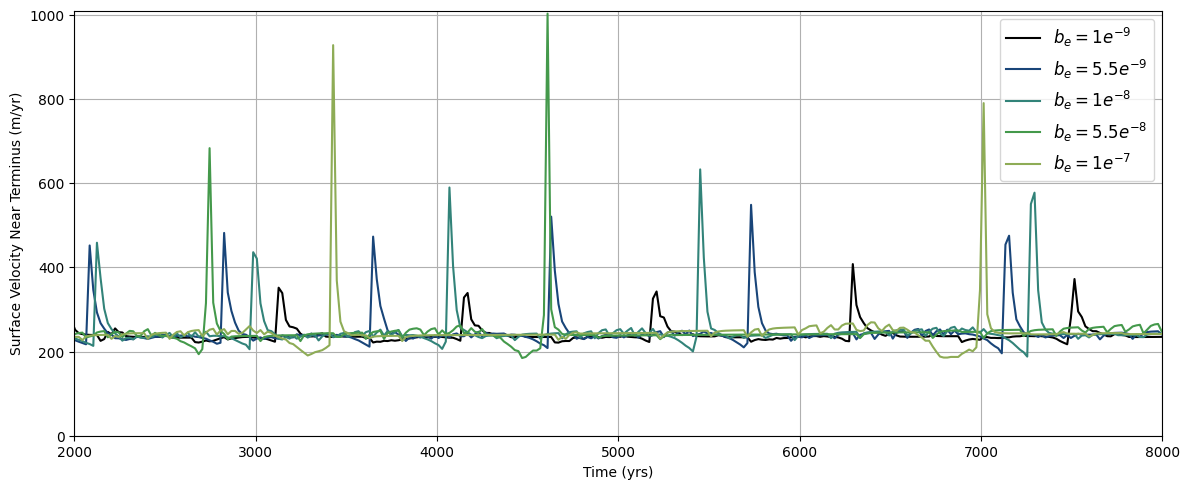

In [225]:
from scipy.interpolate import interp1d

common_times = np.linspace(0, 10000, 500)
cmap = plt.colormaps['gist_earth']
# cmap = truncate_colormap(cmap, 0.25, 1.0)
cmap = truncate_colormap(cmap, 0.0, 0.6)
colors = cmap(np.linspace(0, 1, len(surf_vels)))

fig, ax = plt.subplots(figsize=(12, 5))

for i, us_dict in enumerate(surf_vels):
    term_surface_velocity = []
    times = []

    for t in sorted(us_dict.keys()):
        us_ = us_dict[t]
        notNAN = np.where(np.isfinite(us_))[0]

        if len(notNAN) > 0:
            terminus = notNAN[-1]
        else:
            terminus = None

        if terminus is not None and terminus >= 50:
            term_usvel = us_[terminus - 50]
        else:
            term_usvel = 0

        if np.isnan(term_usvel):
            term_usvel = 0

        term_surface_velocity.append(term_usvel)
        times.append(t)

    times = np.array(times)
    term_surface_velocity = np.array(term_surface_velocity)

    # Sort for interpolation
    sorted_indices = np.argsort(times)
    times = times[sorted_indices]
    term_surface_velocity = term_surface_velocity[sorted_indices]

    # Interpolate to common time grid
    interp_func = interp1d(times, term_surface_velocity, bounds_error=False, fill_value="extrapolate")
    interp_speeds = interp_func(common_times)

    plt.plot(common_times, interp_speeds, label=labels[i], color=colors[i])

plt.xlabel('Time (yrs)')
plt.ylabel('Surface Velocity Near Terminus (m/yr)')
plt.legend(fontsize = 12)
# plt.title('Surface Velocities: Tested $b_{e}$ Values')
plt.xlim(2000,8000)
plt.ylim(0,1010)
plt.grid(True)
plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/BE_Vel.svg", format ="svg", bbox_inches='tight')


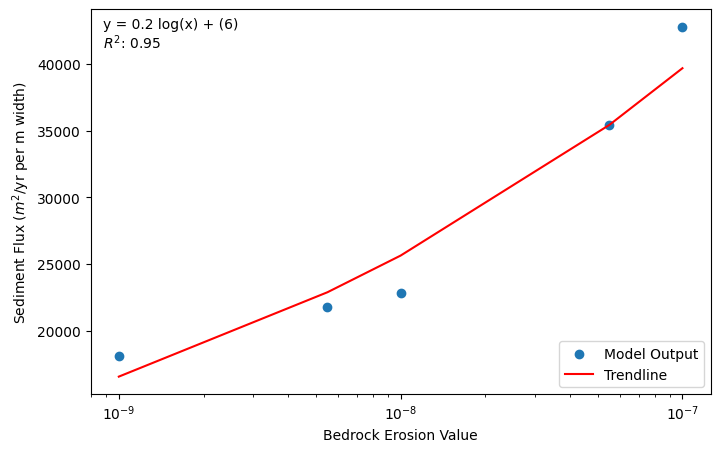

In [231]:
BEs = np.array([1e-9, 5.5e-9, 1e-8, 5.5e-8, 1e-7])
maxs_Qs = np.array([MAX_1e9, MAX_55e9, MAX_1e8, MAX_55e8, MAX_1e7])
log_BEs = np.log10(BEs)
log_Qs = np.log10(maxs_Qs)

# Fit line in log-log space
coeffs = np.polyfit(log_BEs, log_Qs, 1)
a = 10**coeffs[1]
b = coeffs[0]
Qs_trend = a * BEs**b

# R^2
R_2 = r2_score(maxs_Qs, Qs_trend)


fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(BEs, maxs_Qs, label = 'Model Output')
plt.plot(BEs, Qs_trend, color='red', label='Trendline')
plt.text(0.02, 0.9, f'$R^2$: {R_2:.2f}', transform=plt.gca().transAxes)
plt.text(0.02, 0.95, f'y = {coeffs[0]:.1f} log(x) + ({coeffs[1]:.0f})', transform=plt.gca().transAxes)
plt.xlabel("Bedrock Erosion Value")
plt.ylabel("Sediment Flux ($m^{2}$/yr per m width)")
# plt.title("Bedrock Erosion Effect on Sediment Flux")
plt.legend()
plt.xscale('log')
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/BE_VS_QS.svg", format ="svg", bbox_inches='tight')


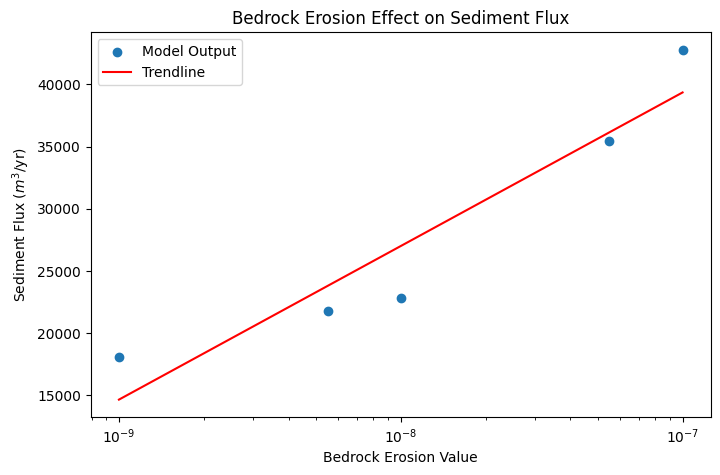

In [179]:
BEs = np.array([1e-9, 5.5e-9, 1e-8, 5.5e-8, 1e-7])
maxs_Qs = np.array([MAX_1e9, MAX_55e9, MAX_1e8, MAX_55e8, MAX_1e7])
log_BEs = np.log10(BEs)
coeffs = np.polyfit(log_BEs, maxs_Qs, 1)
p = np.poly1d(coeffs)
Qs_trend = p(log_BEs)
R_2 = r2_score(maxs_Qs, Qs_trend)


fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(BEs, maxs_Qs, label = 'Model Output')
plt.plot(BEs, Qs_trend, color='red', label='Trendline')
# plt.text(0.25, 0.9, f'$R^2$: {R_2:.2f}', transform=plt.gca().transAxes)
# plt.text(0.2, 0.95, f'y = {coeffs[0]:.2f} log(x) + ({coeffs[1]:.2f})', transform=plt.gca().transAxes)
plt.xlabel("Bedrock Erosion Value")
plt.ylabel("Sediment Flux ($m^{3}$/yr)")
plt.title("Bedrock Erosion Effect on Sediment Flux")
plt.legend()
plt.xscale('log')
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/BedrockErosion/Be_vs_Qs.svg", format="svg", bbox_inches='tight')


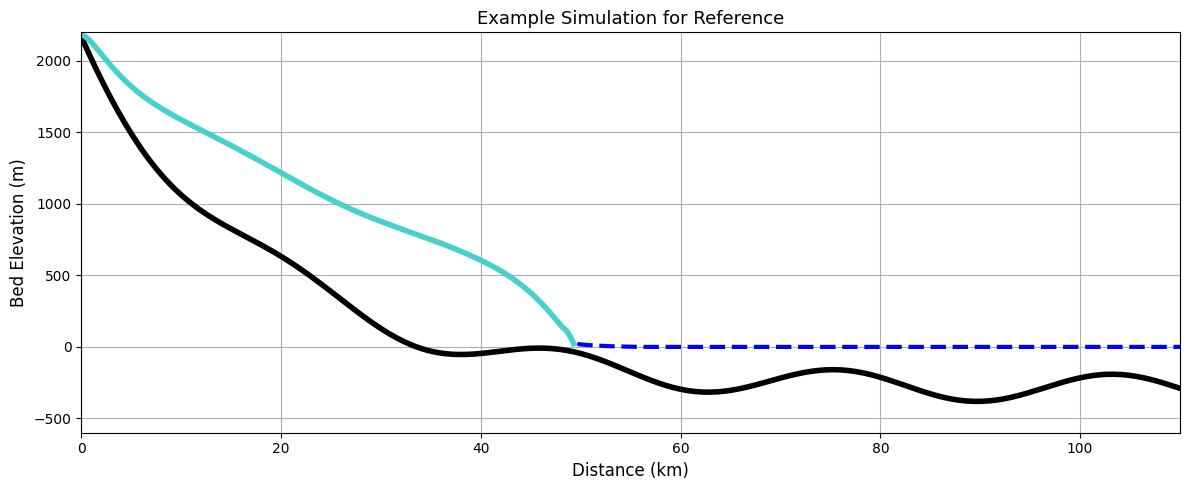

In [180]:
BEs = np.array([1e-9, 5.5e-9, 1e-8, 5.5e-8, 1e-7])
num_points = len(next(iter(bed_dict_1e9.values())))
x_km = mesh_index_to_km(np.arange(num_points))

# Grab original bed (assuming t=0 in all dicts)
original_bed = bed_dict_1e9[0]
final_time = max(surf_dict_1e8.keys())
final_surface = surf_dict_1e8[final_time]
split_index = np.where(x_km >= 49.5)[0][0]  # index where it hits 50 km


# Create figure
fig, ax = plt.subplots(figsize=(12, 5))

# Plot original bed
plt.plot(x_km, original_bed, 'black', label='Original Bed', linewidth =4)

plt.plot(x_km[:split_index], final_surface[:split_index], color='mediumturquoise', linewidth=4)
plt.plot(x_km[split_index:], final_surface[split_index:], color='blue', linewidth = 3, linestyle = 'dashed')
plt.xlabel("Distance (km)", fontsize = 12)
plt.ylabel("Bed Elevation (m)", fontsize = 12)
plt.title("Example Simulation for Reference", fontsize = 13)
plt.xlim(0,110)
plt.ylim(-600,2200)
plt.grid()
plt.tight_layout()
plt.show()

fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Methods/Model/Reference_GlacierProfile.svg", format ="svg", bbox_inches='tight')